In the notebook, we will go through RNN cell to the LSTM cell. The following is the simple RNN cell and how it works.

In [1]:
import logging
logging.basicConfig(level=logging.INFO, 
                    datefmt='%Y-%m-%d %H:%M',
                    format="%(asctime)s - %(levelname)s : %(message)s")
logging.info("--logging--")

import numpy as np
np.random.seed(3)

import matplotlib.pyplot as plt

2022-03-30 07:39 - INFO : --logging--


# RNN to LSTM

## RNN Cell

$$h_t = tanh(h_{t-1}W_h + x_tW_t + b)$$

where $h_t$ is the hidden state, $W$ are weights for training, $t$ is the timestamp, and $b$ is the bias.

In [ ]:
class RNN:
  """Implement the RNN cell."""

  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    s = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(s)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    return dx, dh_prev    

## Issues to RNN

After several iterations, you'll find something wrong that it is hard to train the model.


### Gradient Exploding

In [ ]:
N = 2  # batch size
H = 3  # hidden vector's dimension
T = 20 # time seqence length

In [ ]:
dh = np.ones((N, H))
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh ** 2)) / N
  norm_list.append(norm)

Text(0, 0.5, 'norm')

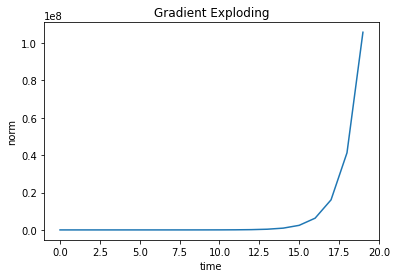

In [ ]:
plt.plot(norm_list)
plt.xlim(-1, 20)
plt.title("Gradient Exploding")
plt.xlabel('time')
plt.ylabel('norm')

### Gradient Vanishing

In [ ]:
decreasing = 0.5

In [ ]:
Wh = np.random.randn(H, H) * decreasing

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh ** 2)) / N
  norm_list.append(norm)

Text(0, 0.5, 'norm')

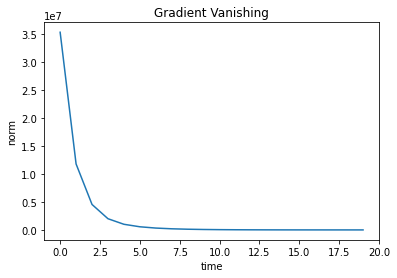

In [ ]:
plt.plot(norm_list)
plt.xlim(-1, 20)
plt.title("Gradient Vanishing")
plt.xlabel('time')
plt.ylabel('norm')

## Gradient Clipping

In [ ]:
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

In [ ]:
grads

[array([[0.61528931, 2.42675422, 9.71602606],
        [2.30584204, 6.91477511, 6.50476858],
        [7.23939139, 4.75088611, 5.96663775]]),
 array([[0.66969424, 0.72562138, 1.98976026],
        [1.51860997, 1.00104345, 1.29293865],
        [5.53277732, 1.87814825, 9.52101243]])]

In [ ]:
def clip_grads(grads, max_norm):
  """A simple way of applying clipping to gradients."""
  total_norm = 0
  
  for grad in grads:
    total_norm += np.sum(grad ** 2)
    
  total_norm = np.sqrt(total_norm)
  rate = max_norm / (total_norm + 1e-6)
  
  if rate < 1:
    for grad in grads:
      grad *= rate

In [ ]:
clip_grads(grads, max_norm)
grads

[array([[0.14643184, 0.57753984, 2.31230345],
        [0.54876412, 1.64563766, 1.54806078],
        [1.72289263, 1.13065674, 1.41999177]]),
 array([[0.1593796 , 0.17268962, 0.47354026],
        [0.36141186, 0.23823693, 0.30770466],
        [1.31673793, 0.44697787, 2.26589243]])]

## LSTM Cell

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
class LSTM:
  """Implement LSTM cell."""

  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    # slice, all of f,g,i,o sizes are equal to (N x H)
    f = A[:, :H]
    g = A[:, H:H*2]
    i = A[:, H*2:H*3]
    o = A[:, H*3:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = c_prev * f + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
    tanh_c_next = np.tanh(c_next)
    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
    dc_prev = ds * f
    
    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i
    
    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)
    
    dA = np.hstack((df, dg, di, do))
    
    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)
    
    return dx, dh_prev, dc_prev 

# Architect the Biredirection LSTM Model

In the following, we are going to build a bidirectional LSTM model for the sentiment analysis. It is a hello world dataset for the text classification.

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow as tf
log = logging.getLogger('tensorflow')
log.setLevel(logging.INFO)
log.info("Tensorflow Version {}".format(str(tf.__version__)))
log.info("GPU is{} available.".format( \
  "" if tf.config.list_physical_devices("GPU") else " not"))

2022-03-30 07:39 - INFO : NumExpr defaulting to 2 threads.
2022-03-30 07:39 - INFO : Tensorflow Version 2.8.0
2022-03-30 07:39 - INFO : GPU is available.


## Setup the input pipeline.

In [3]:
dataset, info = tfds.load("imdb_reviews", 
                          with_info=True, 
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

2022-03-30 07:39 - INFO : No config specified, defaulting to first: imdb_reviews/plain_text
2022-03-30 07:39 - INFO : Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imdb_reviews/plain_text/1.0.0
2022-03-30 07:39 - INFO : Load dataset info from /tmp/tmpa0fpwmk5tfds
2022-03-30 07:39 - INFO : Field info.config_name from disk and from code do not match. Keeping the one from code.
2022-03-30 07:39 - INFO : Field info.config_description from disk and from code do not match. Keeping the one from code.
2022-03-30 07:39 - INFO : Field info.citation from disk and from code do not match. Keeping the one from code.
2022-03-30 07:39 - INFO : Generating dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


2022-03-30 07:39 - INFO : Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /root/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.b1edaa6ceb62459e8f62ee0f5aab6a3b...
2022-03-30 07:39 - INFO : Generating split train
2022-03-30 07:39 - INFO : Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1CMIKO/imdb_reviews-train.tfrecord. Shard lengths: [25000]
2022-03-30 07:39 - INFO : Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1CMIKO/imdb_reviews-train.tfrecord


2022-03-30 07:39 - INFO : Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1CMIKO/imdb_reviews-test.tfrecord. Shard lengths: [25000]
2022-03-30 07:39 - INFO : Generating split unsupervised


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1CMIKO/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1CMIKO/imdb_reviews-unsupervised.tfrecord


2022-03-30 07:40 - INFO : Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1CMIKO/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
2022-03-30 07:40 - INFO : Skipping computing stats for mode ComputeStatsMode.SKIP.
2022-03-30 07:40 - WARNING : Dataset is using deprecated text encoder API which will be removed soon. Please use the plain_text version of the dataset and migrate to `tensorflow_text`.
2022-03-30 07:40 - INFO : Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Let's take a look at the data.

In [4]:
for _string, _label in train_dataset.take(1):
  print(_string)
  print(_label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [5]:
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 10

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for examples, labels in train_dataset.take(1):
  print(examples.numpy()[:3])
  print(labels.numpy()[:3])

[b"Sniffing girl's panties kills a guy...and a stupid freaky puppet says a lot of stupid freaky things......My eyes could not leave the screen, my finger could not leave the Fast Forward button....I had to rewatch this spectacle to see if I had really experienced what I thought...I did.....God help us all!"
 b'This program didn\'t do it for me, although I\'m a fan of the genre. The major factor that disappointed me was that there was not a single scene which was not dominated by the main character. This made it a bit two-dimensional and I gave up before the program was over.<br /><br />I was hoping to leave my critique there as I\'m no movie critic, however, the guidelines on IMDb state that you must put in 10 lines of commentary. It did remind me of Hudson Hawk in the way the main character is in every single scene, and I would hope that the writers of this program could employ some more diversity to engage with the viewers. I don\'t doubt the talent of any of the cast and crew, it\'s

## Creating the text encoder

The raw text must be processed before using it for training the model and for inferece. You have to process the raw text in the TFDS pipeline as well. Here for the TFDS pipeline data, you can use `TextVectorization` for preprocessing the raw data in the pipeline.

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# adapt the train dataset for encoder
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt()` method sets the layer's vocabulary. The following is the first 20 tokens. After the padding and unknown tokens, the tokens are sorted by frequency.

In [8]:
vocabs = np.array(encoder.get_vocabulary())
vocabs[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded corresponding to the longest sequence in the batch. You can also limit the length of text by `output_sequence_length`.

In [9]:
encoded_examples = encoder(examples[:3]).numpy()
encoded_examples

array([[  1, 476,   1,   1,   4,   1,   4, 375,   1,   1, 538,   4, 169,
          5, 375,   1,   1, 516,  96,  22, 546,   2, 293,  56,   1,  96,
         22, 546,   2, 828, 970,   1,  67,   6,   1,  11,   1,   6,  68,
         45,  10,  67,  63,   1,  49,  10,   1,   1, 328, 170,  32,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [ 11,   1, 153,  82,   9,  16,  70, 255, 142,   4, 331,   5,   2,
        533,   2, 648,   1,  12, 704,  70,  14,  12,  48,  14,  22,   4,
        687, 135,

You can also reverse the indices back to the text, but it is in theory impossible. 

(1) The default operation in `TextVectorization` is `lower_and_strip_punctuation`.

(2) A limited vocabulary size is applied and lack of information for those `unknown` tokens.

In [10]:
for t in range(encoded_examples.shape[0]):
  print("Origin:     {}".format(examples[t]))
  print("Round-trip: {}".format(' '.join(vocabs[encoded_examples[t]])))
  print()

Origin:     b"Sniffing girl's panties kills a guy...and a stupid freaky puppet says a lot of stupid freaky things......My eyes could not leave the screen, my finger could not leave the Fast Forward button....I had to rewatch this spectacle to see if I had really experienced what I thought...I did.....God help us all!"
Round-trip: [UNK] girls [UNK] [UNK] a [UNK] a stupid [UNK] [UNK] says a lot of stupid [UNK] [UNK] eyes could not leave the screen my [UNK] could not leave the fast forward [UNK] had to [UNK] this [UNK] to see if i had really [UNK] what i [UNK] [UNK] help us all                                                                                                 

Origin:     b'This program didn\'t do it for me, although I\'m a fan of the genre. The major factor that disappointed me was that there was not a single scene which was not dominated by the main character. This made it a bit two-dimensional and I gave up before the program was over.<br /><br />I was hoping to leave my 

## Creating the Model

![https://www.tensorflow.org/text/tutorials/images/bidirectional.png](https://www.tensorflow.org/text/tutorials/images/bidirectional.png)

* The first layer is the `encoder` that we had implemented before.
* The layer after the encoder is the `embedding` layer. Its dimension is M (the number of vocabulary) x N (the dimension of the output). In other words, an embedding layer stores one vector per word. When called, it converts the sequences of word indices into sequences of vectors. The embedding layer can be trained and its values are related to the task. In usual, words with similar meanings often have similar vectors.
* A RNN processes sequence input by iterating through the elements. RNNs pass the outputs from one timestamp to their input on the next timestamp. The same operations are taken to the LSTMs and GRUs.
You can also wrap the RNN layer with `tf.keras.layers.Bidirectional`. This propagates the input forward and backward through the RNN layer, and then concatenated the final outputs from these two different ways.
The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't require to pass through every timestamp. The main disadvantage of a bidirectional RNN is that you can't predict the result in an efficient way.
* After the bidirectional layer, you can add `tf.keras.layers.Dense` layer for summarizing, and a layer for having the classification output.


In [19]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(
    input_dim=len(vocabs),
    output_dim=64,
    # here we use make_zero to tackle the variable sequence length
    mask_zero=True), 
  tf.keras.layers.Bidirectional(
    layer=tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=1)
])

Using `Sequential` to build the model meets there is one input and one output. Otherwise, if you want to build or use the `stateful RNN` model, you should consider the functional API for building the model to get multiple returns from the API.

The embedding layer uses `masking` to handle the variable sequence length, in tensorflow, this also makes the following layers supporting masking.

In [12]:
for layer in model.layers:
  print("Name: {} -> Supporting Masking: {}".format(
    layer.name, layer.supports_masking
  ))

Name: text_vectorization -> Supporting Masking: False
Name: embedding -> Supporting Masking: True
Name: bidirectional -> Supporting Masking: True
Name: dense -> Supporting Masking: True
Name: dense_1 -> Supporting Masking: True


We now can do the prediction to the text for testing the model.

In [13]:
for examples, _ in train_dataset.take(1):
  predictions = model.predict(examples)
print(predictions[:5])

[[-0.00193436]
 [-0.01853943]
 [-0.00563435]
 [ 0.00322526]
 [ 0.0068056 ]]


We can also verify the masking for variable sequence length by adding the padding.

In [14]:
padding = "a " * 5000
predictions = model.predict(np.array([examples.numpy()[0], padding]))
print(predictions)

[[-0.00193436]
 [ 0.01225825]]


You can find out the first result is identical.

## Training the Model

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_value = tf.keras.metrics.Mean(name="loss_value")
accuracy = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

EPOCHS = 10
VALID_EPOCHS = 1

TRAIN_LOSS = 0.0
TRAIN_ACC = 0.0
TEST_LOSS = 0.0
TEST_ACC = 0.0

TRAIN_LOSS_HIST = []
TRAIN_ACC_HIST = []
TEST_LOSS_HIST = []
TEST_ACC_HIST = []

for epoch in range(EPOCHS):

  loss_value.reset_states()
  accuracy.reset_states()

  for examples, labels in train_dataset:
    with tf.GradientTape() as tape:
      preds = model(examples, training=True)
      loss = loss_object(labels, preds)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    loss_value(loss)
    accuracy(labels, preds)

  TRAIN_LOSS = loss_value.result()
  TRAIN_ACC = accuracy.result()
  TRAIN_LOSS_HIST.append(TRAIN_LOSS.numpy())
  TRAIN_ACC_HIST.append(TRAIN_ACC.numpy())
  
  if (epoch + 1) % VALID_EPOCHS == 0:

    loss_value.reset_states()
    accuracy.reset_states()

    for examples, labels in test_dataset:
      preds = model(examples, training=False)
      loss = loss_object(labels, preds)
      loss_value(loss)
      accuracy(labels, preds)

    TEST_LOSS = loss_value.result()
    TEST_ACC = accuracy.result()
    TEST_LOSS_HIST.append(TEST_LOSS.numpy())
    TEST_ACC_HIST.append(TEST_ACC.numpy())

    print("Epoch {}: Loss {:.4f}, Acc {:.2%}, Val_Loss {:.4f}, Val_Acc {:.2%}".format(
        epoch + 1, TRAIN_LOSS, TRAIN_ACC, TEST_LOSS, TEST_ACC))
  else:
    print("Epoch {}: Loss {:.4f}, Acc {:.2%}".format(
      epoch + 1, TRAIN_LOSS, TRAIN_ACC))

Epoch 1: Loss 0.6895, Acc 49.95%, Val_Loss 0.6581, Val_Acc 53.66%
Epoch 2: Loss 0.5198, Acc 71.81%, Val_Loss 0.4104, Val_Acc 82.84%
Epoch 3: Loss 0.3742, Acc 83.52%, Val_Loss 0.3596, Val_Acc 82.39%
Epoch 4: Loss 0.3423, Acc 85.27%, Val_Loss 0.3527, Val_Acc 86.03%
Epoch 5: Loss 0.3229, Acc 86.40%, Val_Loss 0.3254, Val_Acc 85.97%
Epoch 6: Loss 0.3137, Acc 86.56%, Val_Loss 0.3407, Val_Acc 86.31%
Epoch 7: Loss 0.3069, Acc 87.13%, Val_Loss 0.3336, Val_Acc 86.37%
Epoch 8: Loss 0.3036, Acc 87.21%, Val_Loss 0.3465, Val_Acc 86.16%
Epoch 9: Loss 0.3044, Acc 87.28%, Val_Loss 0.3209, Val_Acc 85.83%
Epoch 10: Loss 0.3005, Acc 87.25%, Val_Loss 0.3233, Val_Acc 85.84%


## Training History

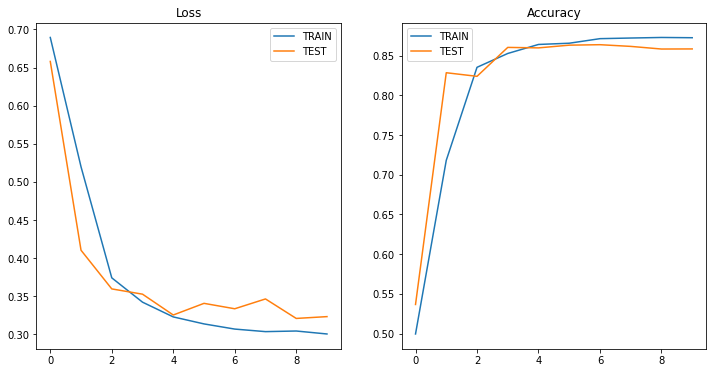

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(TRAIN_LOSS_HIST)
ax[0].plot(TEST_LOSS_HIST)
ax[0].legend(["TRAIN", "TEST"])
ax[0].set_title("Loss")

ax[1].plot(TRAIN_ACC_HIST)
ax[1].plot(TEST_ACC_HIST)
ax[1].legend(["TRAIN", "TEST"])
ax[1].set_title("Accuracy")
plt.show()

# More Bidirectional Stacks

You can build a bidirectional model wrapping the LSTM cells. This is what the previous model did. In the following we are going to build a bidirectional model with more than 1 bidirectional layers.

In Tensorflow, you can easily build the model with more stacks by using the same API `tf.keras.layers.Bidirectional`. However, there is a little bit different for you to use the parameter `return_sequences`, which is false by default.

* If the `return_sequence` is `false`, the model would concatenate the final result whose shape is `[batch_size, output_feature]`.

* If the `return_sequence` is `true`, the model would collect the result from each timestime and pass it to the next layer. The shape for the result would be `[batch_size, timestamp, output_feature]`.

In [24]:
bimodel = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(
    input_dim=len(vocabs), 
    output_dim=64, 
    mask_zero=True),
  tf.keras.layers.Bidirectional(
    layer=tf.keras.layers.LSTM( 
      units=64, return_sequences=True
    )
  ),
  tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(1)
])

bimodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

The above is the example of how to architect the multi-stack bidirectional model. The rest is the same to the previous step.

In [25]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_value = tf.keras.metrics.Mean(name="loss_value")
accuracy = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

EPOCHS = 10
VALID_EPOCHS = 1

TRAIN_LOSS = 0.0
TRAIN_ACC = 0.0
TEST_LOSS = 0.0
TEST_ACC = 0.0

TRAIN_LOSS_HIST = []
TRAIN_ACC_HIST = []
TEST_LOSS_HIST = []
TEST_ACC_HIST = []

for epoch in range(EPOCHS):

  loss_value.reset_states()
  accuracy.reset_states()

  for examples, labels in train_dataset:
    with tf.GradientTape() as tape:
      preds = bimodel(examples, training=True)
      loss = loss_object(labels, preds)
      gradients = tape.gradient(loss, bimodel.trainable_variables)
      optimizer.apply_gradients(zip(gradients, bimodel.trainable_variables))
    
    loss_value(loss)
    accuracy(labels, preds)

  TRAIN_LOSS = loss_value.result()
  TRAIN_ACC = accuracy.result()
  TRAIN_LOSS_HIST.append(TRAIN_LOSS.numpy())
  TRAIN_ACC_HIST.append(TRAIN_ACC.numpy())
  
  if (epoch + 1) % VALID_EPOCHS == 0:

    loss_value.reset_states()
    accuracy.reset_states()

    for examples, labels in test_dataset:
      preds = bimodel(examples, training=False)
      loss = loss_object(labels, preds)
      loss_value(loss)
      accuracy(labels, preds)

    TEST_LOSS = loss_value.result()
    TEST_ACC = accuracy.result()
    TEST_LOSS_HIST.append(TEST_LOSS.numpy())
    TEST_ACC_HIST.append(TEST_ACC.numpy())

    print("Epoch {}: Loss {:.4f}, Acc {:.2%}, Val_Loss {:.4f}, Val_Acc {:.2%}".format(
        epoch + 1, TRAIN_LOSS, TRAIN_ACC, TEST_LOSS, TEST_ACC))
  else:
    print("Epoch {}: Loss {:.4f}, Acc {:.2%}".format(
      epoch + 1, TRAIN_LOSS, TRAIN_ACC))

Epoch 1: Loss 0.6610, Acc 54.02%, Val_Loss 0.4769, Val_Acc 77.08%
Epoch 2: Loss 0.4066, Acc 81.00%, Val_Loss 0.3523, Val_Acc 84.20%
Epoch 3: Loss 0.3402, Acc 84.86%, Val_Loss 0.3372, Val_Acc 83.79%
Epoch 4: Loss 0.3176, Acc 86.13%, Val_Loss 0.3292, Val_Acc 86.27%
Epoch 5: Loss 0.3078, Acc 86.65%, Val_Loss 0.3206, Val_Acc 86.03%
Epoch 6: Loss 0.3038, Acc 86.74%, Val_Loss 0.3191, Val_Acc 85.53%
Epoch 7: Loss 0.2977, Acc 87.14%, Val_Loss 0.3183, Val_Acc 86.29%
Epoch 8: Loss 0.2937, Acc 87.17%, Val_Loss 0.3219, Val_Acc 86.37%
Epoch 9: Loss 0.2942, Acc 87.30%, Val_Loss 0.3249, Val_Acc 86.33%
Epoch 10: Loss 0.2909, Acc 87.47%, Val_Loss 0.3435, Val_Acc 86.23%


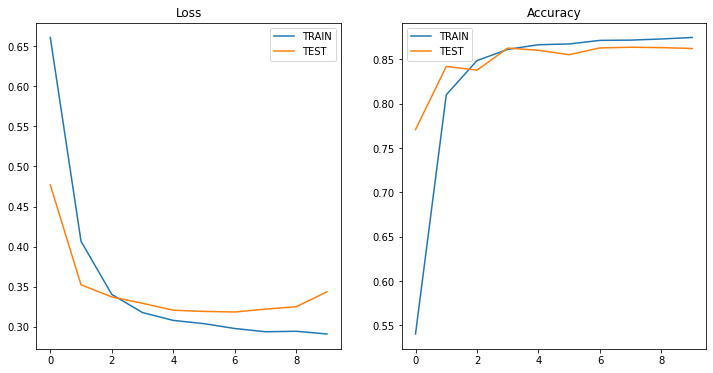

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(TRAIN_LOSS_HIST)
ax[0].plot(TEST_LOSS_HIST)
ax[0].legend(["TRAIN", "TEST"])
ax[0].set_title("Loss")

ax[1].plot(TRAIN_ACC_HIST)
ax[1].plot(TEST_ACC_HIST)
ax[1].legend(["TRAIN", "TEST"])
ax[1].set_title("Accuracy")
plt.show()